# Wikipedia NLP Analysis

## Overview
This notebook performs comprehensive NLP analysis on a corpus of Wikipedia articles, including:
- Text preprocessing and cleaning
- Document clustering (KMeans, DBSCAN, OPTICS)
- Word embeddings (GloVe)
- Dimensionality reduction and visualization
- Multi-label classification

## Dataset
- **Source**: Wikipedia articles
- **Size**: 289 documents
- **Features**: Article text, categories, metadata


In [2]:
import os
import re
import wikipediaapi as wiki_api

class WikipediaReader():
    def __init__(self, dir = "articles"):
        self.pages = set()
        self.article_path = os.path.join("./", dir)
        self.wiki = wiki_api.Wikipedia(user_agent = 'jmoses126@gmail.com',
                language = 'en',
                extract_format=wiki_api.ExtractFormat.WIKI)
        try:
            os.mkdir(self.article_path)
        except Exception as e:
            pass

    def reset(self):
        """Reset the reader by clearing all stored pages."""
        self.pages = set()

    def _get_page_title(self, article):
        return re.sub(r'\s+','_', article)

    def add_article(self, article):
        try:
            page = self.wiki.page(self._get_page_title(article))
            if page.exists():
                self.pages.add(page)
                return(page)
        except Exception as e:
            print(e)

    def list(self):
        return self.pages

    def process(self, update=False):
        for page in self.pages:
            filename = re.sub('\\s+', '_', f'{page.title}')
            filename = re.sub(r'[\(\):]','', filename)
            file_path = os.path.join(self.article_path, f'{filename}.txt')
            if update or not os.path.exists(file_path):
                print(f'Downloading {page.title} ...')
                content = page.text
                with open(file_path, 'w') as file:
                    file.write(content)
            else:
                print(f'Not updating {page.title} ...')

    def crawl_pages(self, article, depth = 3, total_number = 1000):
        print(f'Crawl {total_number} :: {article}')

        page = self.add_article(article)
        childs = set()

        if page:
            for child in page.links.keys():
                if len(self.pages) < total_number:
                    print(f'Add article {len(self.pages)}/{total_number} {child}')
                    self.add_article(child)
                    childs.add(child)

        depth -= 1
        if depth > 0:
            for child in sorted(childs):
                if len(self.pages) < total_number:
                    self.crawl_pages(child, depth, len(self.pages))

    def get_categories(self, title):
        page = self.add_article(title)
        if page:
            if (list(page.categories.keys())) and (len(list(page.categories.keys())) > 0):
                categories = [c.replace('Category:','').lower() for c in list(page.categories.keys())
                   if c.lower().find('articles') == -1
                   and c.lower().find('pages') == -1
                   and c.lower().find('wikipedia') == -1
                   and c.lower().find('cs1') == -1
                   and c.lower().find('webarchive') == -1
                   and c.lower().find('dmy dates') == -1
                   and c.lower().find('short description') == -1
                   and c.lower().find('commons category') == -1

                ]
                return dict.fromkeys(categories, 1)
        return {}

In [3]:
import sys
print(sys.executable)


/Users/jmoses2013/Python Projects/gensim_env_312/bin/python


In [4]:
import nltk
from  nltk.corpus.reader.plaintext import CategorizedPlaintextCorpusReader
from time import time

class WikipediaCorpus(CategorizedPlaintextCorpusReader):
    
    def __init__(self, root, fileids, cat_pattern=None, **kwargs):
        """
        Initialize the WikipediaCorpus reader.
        
        :param root: The root directory for corpus files
        :param fileids: File pattern(s) to match
        :param cat_pattern: Regex pattern to extract categories from filenames
        """
        super().__init__(root, fileids, cat_pattern=cat_pattern, **kwargs)

    def vocab(self):
        return nltk.FreqDist(re.sub(r'[^A-Za-z0-9,;\.]+', ' ', word).lower() for word in corpus.words())

    def max_words(self):
        max = 0
        for doc in self.fileids():
            l = len(self.words(doc))
            max = l if l > max else max
        return max

    def describe(self, fileids=None, categories=None):
        started = time()

        return {
            'files': len(self.fileids()),
            'paras': len(self.paras()),
            'sents': len(self.sents()),
            'words': len(self.words()),
            'vocab': len(self.vocab()),
            'max_words': self.max_words(),
            'time': time()-started
            }
        pass

corpus = WikipediaCorpus(root='articles', fileids=r'[^\\.ipynb].*', cat_pattern=r'[.*]')
print(corpus.fileids())

['"Hello,_World!"_program.txt', '15.ai.txt', '2001_A_Space_Odyssey.txt', '2001_A_Space_Odyssey_novel.txt', '2024_Indian_general_election.txt', '3D_optical_data_storage.txt', 'A*_search_algorithm.txt', 'A.I._Artificial_Intelligence.txt', 'ABB.txt', 'ABC_programming_language.txt', 'ACM_Computing_Classification_System.txt', 'ACM_Conference_on_Fairness,_Accountability,_and_Transparency.txt', 'ACM_SIGEVO.txt', 'ADMB.txt', 'AI-assisted_software_development.txt', 'AI_Overviews.txt', 'AI_Safety_Institute.txt', 'AI_Safety_Summit.txt', 'AI_Seoul_Summit.txt', 'AI_aftermath_scenarios.txt', 'AI_agent.txt', 'AI_alignment.txt', 'AI_boom.txt', 'AI_bubble.txt', 'AI_capability_control.txt', 'AI_effect.txt', 'AI_safety.txt', 'AI_slop.txt', 'AI_takeover.txt', 'AI_winter.txt', 'ALGOL.txt', 'ALGOL_60.txt', 'ALGOL_68.txt', 'ANSI_C.txt', 'APL_programming_language.txt', 'AVR_microcontrollers.txt', 'A_priori_and_a_posteriori.txt', 'Abductive_reasoning.txt', 'Ablation.txt', 'Abstract_and_concrete.txt', 'Academic

In [5]:
import ssl

# Fix SSL certificate issue for NLTK downloads on macOS
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

# Download required NLTK data
nltk.download('punkt_tab', quiet=True)

class WikipediaPlaintextCorpus(CategorizedPlaintextCorpusReader):
    def __init__(self, root_path):
        # Need to provide both root AND fileids
        super().__init__(root_path, r'.*\.txt', cat_pattern=r'.*')
    
    def vocab(self):
        return nltk.FreqDist(re.sub(r'[^A-Za-z0-9,;\.]+', ' ', word).lower() for word in self.words())
    
    def max_words(self):
        max_count = 0
        for doc in self.fileids():
            word_count = len(self.words(doc))
            max_count = word_count if word_count > max_count else max_count
        return max_count
    
    def describe(self, fileids=None, categories=None):
        started = time()
        
        return {
            'files': len(self.fileids()),
            'paras': len(self.paras()),
            'sents': len(self.sents()),
            'words': len(self.words()),
            'vocab': len(self.vocab()),
            'max_words': self.max_words(),
            'time': time() - started
        }

root_path = './articles'
corpus = WikipediaPlaintextCorpus(root_path)
print(corpus.describe())

{'files': 289, 'paras': 11741, 'sents': 45944, 'words': 1076621, 'vocab': 38675, 'max_words': 19012, 'time': 3.8802380561828613}


## 1. Setup and Configuration
Load required libraries and define custom classes for the analysis pipeline.


In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class WikipediaCorpusTransformer(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible transformer that loads Wikipedia corpus data.
    This class is designed to be used in a sklearn Pipeline.
    """
    def __init__(self, root_path):
        self.root_path = root_path
        self.corpus = None

    def fit(self, X=None, y=None):
        """Load the corpus from the root path."""
        self.corpus = WikipediaPlaintextCorpus(self.root_path)
        return self

    def transform(self, X=None):
        """Return the list of file IDs from the corpus."""
        if self.corpus is None:
            self.fit()
        return self.corpus.fileids()

    def get_corpus(self):
        """Return the loaded corpus object."""
        if self.corpus is None:
            self.fit()
        return self.corpus

In [ ]:
class Categorizer(BaseEstimator, TransformerMixin):
    """
    Assigns categories to documents based on Wikipedia page categories.
    """
    def __init__(self, wikipedia_reader):
        self.reader = wikipedia_reader

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Transform file IDs to include category information."""
        categorized_docs = []
        for fileid in X:
            # Extract article title from filename
            title = fileid.replace('.txt', '').replace('_', ' ')
            categories = self.reader.get_categories(title)
            categorized_docs.append({
                'fileid': fileid,
                'title': title,
                'categories': categories
            })
        return categorized_docs


class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    Preprocesses text from the corpus files with comprehensive text cleaning.
    
    Parameters:
    -----------
    root_path : str
        Path to directory containing text files
    lowercase : bool, default=True
        Convert text to lowercase
    remove_stopwords : bool, default=True
        Remove common stopwords using NLTK
    lemmatize : bool, default=True
        Apply lemmatization using WordNetLemmatizer
    remove_punctuation : bool, default=True
        Remove punctuation and special characters
    remove_numbers : bool, default=False
        Remove numeric digits
    min_token_length : int, default=3
        Minimum length for tokens to keep
    """
    def __init__(self, root_path, lowercase=True, remove_stopwords=True, 
                 lemmatize=True, remove_punctuation=True, 
                 remove_numbers=False, min_token_length=3):
        self.root_path = root_path
        self.lowercase = lowercase
        self.remove_stopwords = remove_stopwords
        self.lemmatize = lemmatize
        self.remove_punctuation = remove_punctuation
        self.remove_numbers = remove_numbers
        self.min_token_length = min_token_length
        
        # Initialize lemmatizer and stopwords
        if self.lemmatize:
            from nltk.stem import WordNetLemmatizer
            self.lemmatizer = WordNetLemmatizer()
        if self.remove_stopwords:
            from nltk.corpus import stopwords
            self.stop_words = set(stopwords.words('english'))

    def fit(self, X, y=None):
        return self

    def _clean_text(self, text):
        """Apply comprehensive text cleaning."""
        import re
        
        # Lowercase
        if self.lowercase:
            text = text.lower()
        
        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        
        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)
        
        # Remove numbers if requested
        if self.remove_numbers:
            text = re.sub(r'\d+', '', text)
        
        # Remove punctuation if requested
        if self.remove_punctuation:
            text = re.sub(r'[^\w\s]', ' ', text)
        
        # Remove extra whitespace
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def _process_tokens(self, text):
        """Tokenize and apply token-level processing."""
        # Simple word tokenization
        tokens = text.split()
        
        # Filter short tokens
        tokens = [t for t in tokens if len(t) >= self.min_token_length]
        
        # Remove stopwords
        if self.remove_stopwords:
            tokens = [t for t in tokens if t not in self.stop_words]
        
        # Lemmatize
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(t) for t in tokens]
        
        return ' '.join(tokens)

    def transform(self, X):
        """Read and preprocess text from files."""
        processed_docs = []
        for doc in X:
            fileid = doc['fileid'] if isinstance(doc, dict) else doc
            filepath = os.path.join(self.root_path, fileid)
            
            try:
                with open(filepath, 'r', encoding='utf-8') as f:
                    text = f.read()
                    # Apply comprehensive preprocessing
                    text = self._clean_text(text)
                    text = self._process_tokens(text)
                    processed_docs.append({
                        'text': text,
                        'fileid': fileid,
                        'categories': doc.get('categories', {}) if isinstance(doc, dict) else {}
                    })
            except Exception as e:
                print(f"Error processing {fileid}: {e}")
                
        return processed_docs


class TextTokenizer(BaseEstimator, TransformerMixin):
    """
    Tokenizes text into words and sentences.
    """
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        """Tokenize documents into words."""
        tokenized_docs = []
        for doc in X:
            text = doc['text'] if isinstance(doc, dict) else doc
            # Simple word tokenization
            words = nltk.word_tokenize(text)
            
            tokenized_docs.append({
                'tokens': words,
                'fileid': doc.get('fileid', '') if isinstance(doc, dict) else '',
                'categories': doc.get('categories', {}) if isinstance(doc, dict) else {}
            })
        return tokenized_docs


class BagOfWordVectorizer(BaseEstimator, TransformerMixin):
    """
    Converts tokenized documents to bag-of-words representation.
    """
    def __init__(self, corpus):
        self.corpus = corpus
        self.vocabulary = None

    def fit(self, X, y=None):
        """Build vocabulary from corpus."""
        self.vocabulary = self.corpus.vocab()
        return self

    def transform(self, X):
        """Transform documents to bag-of-words vectors."""
        vectors = []
        for doc in X:
            tokens = doc['tokens'] if isinstance(doc, dict) else doc
            # Create frequency distribution for this document
            word_freq = nltk.FreqDist(tokens)
            vectors.append({
                'vector': dict(word_freq),
                'fileid': doc.get('fileid', '') if isinstance(doc, dict) else '',
                'categories': doc.get('categories', {}) if isinstance(doc, dict) else {}
            })
        return vectors


In [8]:
from sklearn.pipeline import Pipeline

root_path = './articles'

pipeline = Pipeline([
    ('corpus', WikipediaCorpusTransformer(root_path=root_path)),
    ('categorizer', Categorizer(WikipediaReader())),
    ('preprocessor', TextPreprocessor(root_path=root_path)),
    ('tokenizer', TextTokenizer()),
    ('vectorizer', BagOfWordVectorizer(WikipediaPlaintextCorpus(root_path))),
])

In [9]:
import pandas as pd
from sklearn.feature_extraction import DictVectorizer

# Run the pipeline to get the vectorized documents
transformed_data = pipeline.fit_transform(None)

# Create a DataFrame with the results, including preprocessed text
X = pd.DataFrame([{
    'fileid': doc['fileid'],
    'bow': doc['vector'],
    'categories': doc['categories']
} for doc in transformed_data])

# Add preprocessed text by reading from the pipeline's preprocessor output
# We need to re-run just the preprocessing steps to get the text
preprocessed_data = pipeline.named_steps['preprocessor'].transform(
    pipeline.named_steps['categorizer'].transform(
        pipeline.named_steps['corpus'].transform(None)
    )
)

# Add the preprocessed text to the DataFrame
X['preprocessed'] = [doc['text'] for doc in preprocessed_data]

# Add tokens from the tokenizer output
tokenized_data = pipeline.named_steps['tokenizer'].transform(preprocessed_data)
X['tokens'] = [doc['tokens'] for doc in tokenized_data]

# Now create the feature matrix
vectorizer = DictVectorizer(sparse=False)
x_train = vectorizer.fit_transform(X['bow'].to_numpy())

## 2. Document Clustering Analysis
Apply various clustering algorithms to discover document groups.

### 2.1 KMeans Clustering
Partition-based clustering with predefined number of clusters.


In [10]:
from sklearn.cluster import KMeans

# Create and fit KMeans model
kmeans = KMeans(n_clusters=8, random_state=0)
kmeans.fit(x_train)

# Verify that labels were created
print(f"Number of documents clustered: {len(kmeans.labels_)}")
print(f"Cluster assignments: {kmeans.labels_}")

Number of documents clustered: 289
Cluster assignments: [1 4 5 4 2 1 4 4 4 1 1 1 1 1 1 1 1 1 1 7 7 4 7 1 1 1 4 7 7 4 7 7 2 1 2 2 7
 2 7 1 1 1 4 1 7 1 1 7 4 1 1 1 2 0 7 7 7 4 4 1 7 1 1 1 4 1 2 5 1 1 2 7 1 1
 1 1 7 1 7 1 6 7 4 5 7 1 2 5 1 1 1 7 1 7 1 4 1 1 7 1 1 7 1 1 1 4 1 2 1 7 1
 1 1 6 4 1 1 7 1 1 1 5 5 4 5 7 4 1 1 1 1 7 4 7 7 5 6 7 1 7 2 7 7 2 1 7 7 4
 1 1 4 4 1 1 4 2 5 1 0 7 2 1 7 1 1 1 4 1 1 7 2 1 7 1 1 1 4 4 4 1 5 1 1 4 7
 7 1 7 5 1 1 1 1 1 5 1 1 4 2 3 4 2 1 7 7 1 7 1 1 1 1 1 3 4 1 5 1 1 1 4 1 1
 1 2 1 1 7 1 1 2 7 4 7 1 4 4 7 1 1 1 1 3 0 4 5 1 1 2 2 0 2 7 7 2 4 7 1 7 0
 4 4 7 4 7 7 1 1 7 7 7 7 4 1 4 4 1 2 4 7 4 1 2 7 4 0 7 1 7 7]


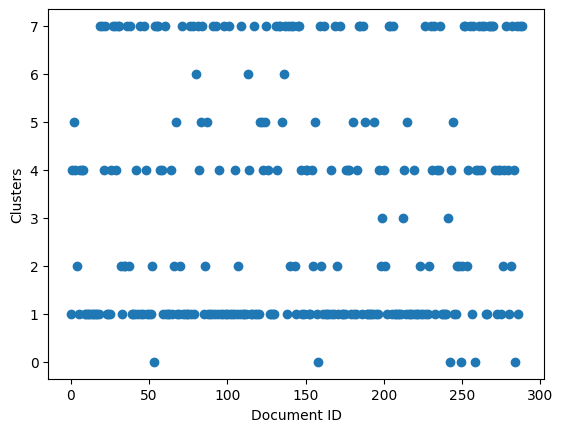

In [11]:
import matplotlib.pyplot as plt

plt.ylabel('Clusters')
plt.xlabel('Document ID')
plt.plot(kmeans.labels_, 'o')

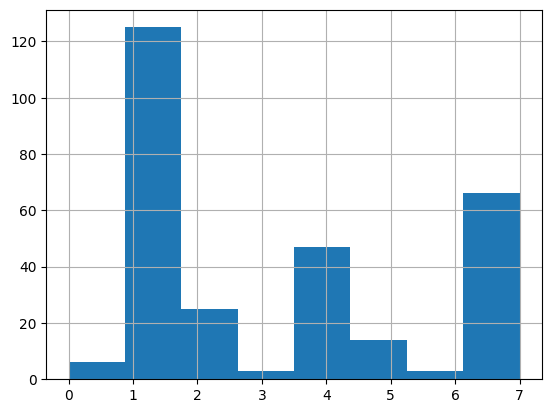

In [12]:
plt.hist(x=kmeans.labels_,  bins=8, density=False)
plt.grid(True)
plt.show()


In [13]:
def get_cluster_articles(c_id, lables):
    # Extract title from fileid by removing .txt and replacing underscores
    return [X['fileid'][i].replace('.txt', '').replace('_', ' ') for i,l in enumerate(lables) if l == c_id]

print(get_cluster_articles(0, kmeans.labels_))

['Adversarial machine learning', 'Automatic differentiation', 'Drag physics', 'Electromagnetic radiation', 'Fairness machine learning', 'String computer science']


In [ ]:
def evaluate_clustering(X, labels, method_name="Clustering"):
    """
    Evaluate clustering quality using multiple metrics.
    
    Parameters:
    -----------
    X : array-like
        Feature matrix used for clustering
    labels : array-like
        Cluster labels assigned to each sample
    method_name : str
        Name of clustering method for display
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics
    """
    from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
    import numpy as np
    
    # Filter out noise points (label -1) for DBSCAN/OPTICS
    mask = labels >= 0
    n_noise = (labels == -1).sum()
    
    if mask.sum() < 2:
        print(f"{method_name}: Insufficient non-noise samples for evaluation")
        return {
            'method': method_name,
            'n_clusters': 0,
            'n_noise': n_noise,
            'n_samples': len(labels),
            'silhouette': None,
            'davies_bouldin': None,
            'calinski_harabasz': None
        }
    
    # Get unique clusters (excluding noise)
    unique_clusters = len(set(labels[mask]))
    
    if unique_clusters < 2:
        print(f"{method_name}: Only {unique_clusters} cluster(s) found")
        return {
            'method': method_name,
            'n_clusters': unique_clusters,
            'n_noise': n_noise,
            'n_samples': len(labels),
            'silhouette': None,
            'davies_bouldin': None,
            'calinski_harabasz': None
        }
    
    # Calculate metrics only on non-noise points
    X_filtered = X[mask]
    labels_filtered = labels[mask]
    
    metrics = {
        'method': method_name,
        'n_clusters': unique_clusters,
        'n_noise': n_noise,
        'n_samples': len(labels),
        'silhouette': silhouette_score(X_filtered, labels_filtered),
        'davies_bouldin': davies_bouldin_score(X_filtered, labels_filtered),
        'calinski_harabasz': calinski_harabasz_score(X_filtered, labels_filtered)
    }
    
    # Print formatted results
    print(f"\n{method_name} Evaluation:")
    print(f"  Samples: {metrics['n_samples']} ({metrics['n_noise']} noise)")
    print(f"  Clusters: {metrics['n_clusters']}")
    print(f"  Silhouette Score: {metrics['silhouette']:.4f} (higher is better, range: -1 to 1)")
    print(f"  Davies-Bouldin Index: {metrics['davies_bouldin']:.4f} (lower is better)")
    print(f"  Calinski-Harabasz Score: {metrics['calinski_harabasz']:.2f} (higher is better)")
    
    return metrics


# Example usage (commented out - uncomment to test after running clustering)
# metrics_kmeans = evaluate_clustering(x_train, kmeans.labels_, "KMeans")


In [ ]:
def plot_elbow(X, k_range=range(2, 21), random_state=42):
    """
    Plot elbow curve to determine optimal number of clusters for KMeans.
    
    Parameters:
    -----------
    X : array-like
        Feature matrix for clustering
    k_range : range or list
        Range of k values to test (default: 2 to 20)
    random_state : int
        Random state for reproducibility
    
    Returns:
    --------
    list : Inertia values for each k
    """
    from sklearn.cluster import KMeans
    import matplotlib.pyplot as plt
    import numpy as np
    
    inertias = []
    k_values = list(k_range)
    
    print("Calculating inertia for different k values...")
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=random_state, n_init=10)
        kmeans.fit(X)
        inertias.append(kmeans.inertia_)
        print(f"  k={k}: inertia={kmeans.inertia_:.2f}")
    
    # Plot elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, inertias, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Number of Clusters (k)', fontsize=12)
    plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
    plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.xticks(k_values)
    
    # Try to identify elbow point using second derivative
    inertias_arr = np.array(inertias)
    if len(inertias_arr) > 2:
        # Calculate second derivative (rate of change of slope)
        first_deriv = np.diff(inertias_arr)
        second_deriv = np.diff(first_deriv)
        # Find point where second derivative is maximum (sharpest turn)
        elbow_idx = np.argmax(second_deriv) + 2  # +2 because of two diff operations
        elbow_k = k_values[elbow_idx]
        
        # Highlight elbow point
        plt.axvline(x=elbow_k, color='r', linestyle='--', alpha=0.7, 
                    label=f'Suggested k={elbow_k}')
        plt.legend()
        print(f"\nSuggested optimal k (elbow point): {elbow_k}")
    
    plt.tight_layout()
    plt.show()
    
    return inertias


# Example usage (commented out - uncomment to run)
# inertias = plot_elbow(x_train, k_range=range(2, 21))


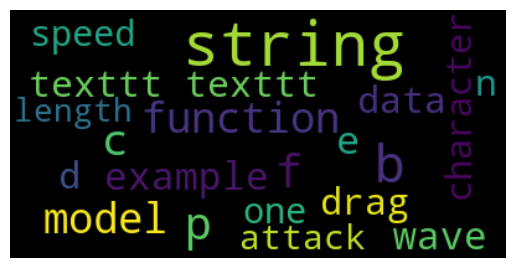

In [14]:
from wordcloud import WordCloud

def wordcloud_for_cluster(c_id, lables):
    text = ' '.join([X['preprocessed'][i] for i,l in enumerate(lables) if l == c_id ])

    wordcloud = WordCloud(max_font_size=50, max_words=20).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

wordcloud_for_cluster(0, kmeans.labels_)


In [15]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer(sparse=False)
x_train = vectorizer.fit_transform(X['bow'])

print(type(x_train))
#numpy.ndarray

print(x_train)
#[[ 15.   0.  10. ...   0.   0.   0.]
# [662.   0. 430. ...   0.   0.   0.]
# [316.   0. 143. ...   0.   0.   0.]
# ...
# [319.   0. 217. ...   0.   0.   0.]
# [158.   0. 147. ...   0.   0.   0.]
# [328.   0. 279. ...   0.   0.   0.]]

print(x_train.shape)
# (272, 52743)

print(vectorizer.get_feature_names_out())
# array([',', ',1', '.', ..., 'zy', 'zygomaticus', 'zygote'], dtype=object)

print(len(vectorizer.get_feature_names_out()))
# 52743


<class 'numpy.ndarray'>
[[27.  0.  0. ...  0.  0.  0.]
 [ 3.  0.  1. ...  0.  0.  0.]
 [ 4.  4. 21. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]]
(289, 49214)
['!' '#' '$' ... '高分' '高分辨率对地观测系统' '鹊桥号']
49214


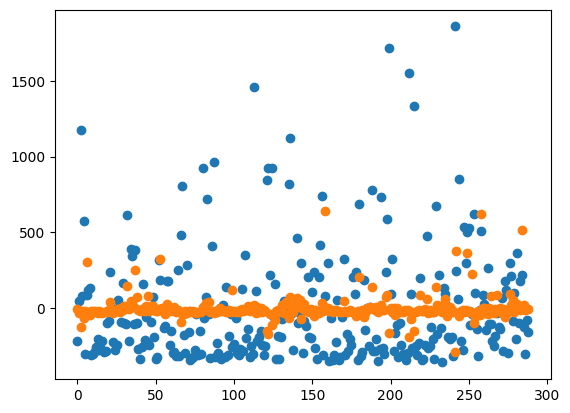

In [16]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def pca_reduce(vec_list, dimensions=2):
    return PCA(dimensions).fit_transform(vec_list)

def d2_plot(data):
    plt.plot(data, 'o')

d2_plot(pca_reduce(x_train,2))





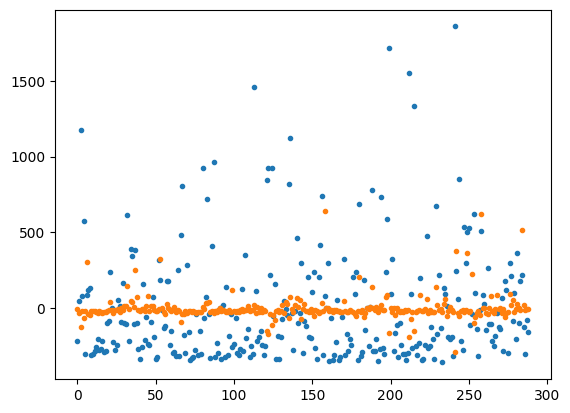

In [17]:
def d2_plot(data):
    plt.plot(data, '.')

d2_plot(pca_reduce(x_train,2))

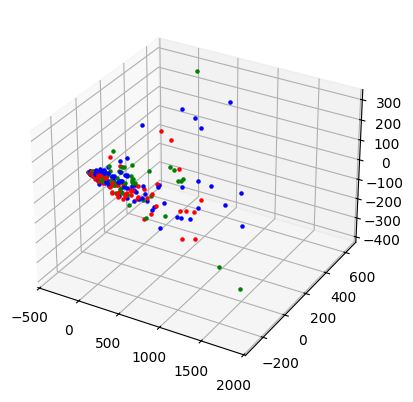

In [18]:
def d3_plot(data):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    for _, v in enumerate(data[:90]):
        ax.scatter(v[0],v[1], v[2],marker='.', color='r')
    for _, v in enumerate(data[90:180]):
        ax.scatter(v[0],v[1], v[2],marker='.', color='g')
    for _, v in enumerate(data[180:]):
        ax.scatter(v[0],v[1], v[2],marker ='.', color='b')

    plt.show()

d3_plot(pca_reduce(x_train,3))


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

x_train = X['preprocessed'].tolist()

vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)

print(x_train.shape)
# (272, 40337)

print(x_train)


(289, 38852)
<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 256194 stored elements and shape (289, 38852)>
  Coords	Values
  (0, 16897)	0.6559822918330022
  (0, 37982)	0.27705065209097296
  (0, 27528)	0.15713627127594826
  (0, 19079)	0.07510935019577994
  (0, 36547)	0.009151228932627795
  (0, 31643)	0.039981066852653235
  (0, 8865)	0.06361819702831546
  (0, 34570)	0.04909819993022891
  (0, 12744)	0.02103508562502941
  (0, 24999)	0.03557932062827105
  (0, 11535)	0.01661272915822756
  (0, 34944)	0.14714231208267683
  (0, 34575)	0.3356683994386065
  (0, 30739)	0.01661272915822756
  (0, 24744)	0.01490604027370081
  (0, 9141)	0.0383541900297163
  (0, 22389)	0.04448417403309118
  (0, 31633)	0.007512532254807633
  (0, 31926)	0.01630894150468294
  (0, 26411)	0.014978313067990912
  (0, 24705)	0.12874952307234222
  (0, 8376)	0.042938865196539736
  (0, 18033)	0.12501052339924104
  (0, 23246)	0.006216784765164929
  (0, 15513)	0.007278985220219028
  :	:
  (288, 6249)	0.01946883156697

In [20]:
import gensim.downloader as api
import numpy as np

vocab = corpus.vocab()
vector_lookup = api.load('glove-wiki-gigaword-50')

def word_vector(tokens):
    return np.array([
        vector_lookup[token]
        for token in tokens
        if token in vocab and token in vector_lookup
    ])

X['word_vector'] = X['tokens'].apply(lambda tokens: word_vector(tokens))


[ 1247  4255 13002  3543  8119]


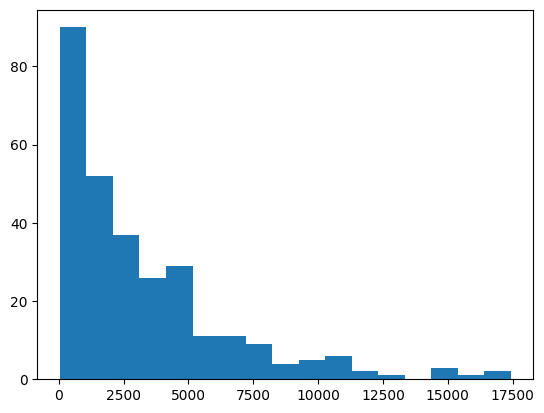

Mean: 3237.8754325259515


In [21]:
word_vector_length = np.array([len(tokens) for tokens in X['word_vector'].to_numpy().flatten()])

print(word_vector_length[:5])
# [760, 157, 7566, 2543, 2086]

bins=int(np.max(word_vector_length)/1000)

plt.hist(x=word_vector_length,  bins=bins, density=False)
plt.show()

print(f'Mean: {word_vector_length.mean()}')


In [23]:
def pad_word_vectors(vec_list, padding_value):
    res = []
    for vec in vec_list:
        con = np.array([v for v in vec]).reshape(-1)
        con_padded = np.pad(con, (0, padding_value))
        con_truncated = con_padded[:padding_value]
        res.append(con_truncated)
    return np.array(res)

def pca_reduce(vec_list, n_components):
    return PCA(n_components).fit_transform(vec_list)

# Use the X DataFrame we already created earlier (no pickle needed!)
x_train = X['word_vector'].to_numpy()

x_train_padded = pad_word_vectors(x_train, 300000)

x_train_2d = pca_reduce(x_train_padded, 2)
x_train_3d = pca_reduce(x_train_padded, 3)

In [25]:
# Fit KMeans on the 2D PCA-reduced vectors to avoid "setting an array element with a sequence" error
model = KMeans(n_clusters=8, random_state=0).fit(x_train_2d)
print(model)
print(model.get_params())
print(model.labels_)

KMeans(random_state=0)
{'algorithm': 'lloyd', 'copy_x': True, 'init': 'k-means++', 'max_iter': 300, 'n_clusters': 8, 'n_init': 'auto', 'random_state': 0, 'tol': 0.0001, 'verbose': 0}
[1 0 2 0 2 3 0 0 5 3 3 3 7 1 7 7 1 3 3 6 6 2 0 1 7 1 0 0 6 5 4 4 2 1 2 2 4
 2 6 7 3 1 5 1 6 7 7 6 0 1 3 3 2 2 6 4 4 5 5 7 4 3 3 3 2 3 2 2 1 3 2 4 3 3
 3 3 6 3 4 3 2 6 0 2 6 3 2 2 3 7 3 6 3 6 3 5 3 4 6 7 7 6 3 3 7 5 3 2 1 4 3
 7 3 2 0 1 1 4 7 3 7 2 2 5 2 4 0 3 1 3 1 6 0 6 6 2 2 6 7 6 2 6 6 2 3 6 4 5
 1 1 0 5 7 3 5 2 2 3 0 0 2 3 6 3 3 1 6 3 3 6 2 3 1 7 1 7 5 0 5 3 2 3 7 5 4
 6 7 6 2 7 3 1 3 7 2 7 3 5 2 2 0 2 3 1 6 3 4 7 3 3 3 3 2 0 7 2 7 3 1 5 3 3
 7 2 7 7 4 1 3 2 4 5 4 3 0 0 0 1 4 1 3 2 5 0 2 1 7 2 2 2 2 4 6 2 0 4 3 6 2
 5 0 4 2 6 4 1 7 4 6 4 6 0 7 5 0 3 2 5 4 0 1 2 6 5 5 4 3 6 4]


In [27]:
model = KMeans(n_clusters=8, random_state=0, n_init="auto").fit(x_train_2d)

print(model.labels_)


[1 0 2 0 2 3 0 0 5 3 3 3 7 1 7 7 1 3 3 6 6 2 0 1 7 1 0 0 6 5 4 4 2 1 2 2 4
 2 6 7 3 1 5 1 6 7 7 6 0 1 3 3 2 2 6 4 4 5 5 7 4 3 3 3 2 3 2 2 1 3 2 4 3 3
 3 3 6 3 4 3 2 6 0 2 6 3 2 2 3 7 3 6 3 6 3 5 3 4 6 7 7 6 3 3 7 5 3 2 1 4 3
 7 3 2 0 1 1 4 7 3 7 2 2 5 2 4 0 3 1 3 1 6 0 6 6 2 2 6 7 6 2 6 6 2 3 6 4 5
 1 1 0 5 7 3 5 2 2 3 0 0 2 3 6 3 3 1 6 3 3 6 2 3 1 7 1 7 5 0 5 3 2 3 7 5 4
 6 7 6 2 7 3 1 3 7 2 7 3 5 2 2 0 2 3 1 6 3 4 7 3 3 3 3 2 0 7 2 7 3 1 5 3 3
 7 2 7 7 4 1 3 2 4 5 4 3 0 0 0 1 4 1 3 2 5 0 2 1 7 2 2 2 2 4 6 2 0 4 3 6 2
 5 0 4 2 6 4 1 7 4 6 4 6 0 7 5 0 3 2 5 4 0 1 2 6 5 5 4 3 6 4]


In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import pandas as pd

x_train = X['preprocessed'].tolist()

vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train)


### 2.2 DBSCAN Clustering
Density-based clustering that can find arbitrary-shaped clusters and identify noise points.


In [ ]:
# DBSCAN Clustering with Parameter Tuning
# DBSCAN works poorly in high-dimensional spaces, so we reduce dimensionality first

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Reduce dimensionality to make DBSCAN effective
print("Reducing dimensionality for DBSCAN...")
pca = PCA(n_components=50, random_state=42)
x_train_pca50 = pca.fit_transform(x_train.toarray() if hasattr(x_train, 'toarray') else x_train)
print(f"Reduced from {x_train.shape[1]} to 50 dimensions")
print(f"Explained variance: {pca.explained_variance_ratio_.sum():.2%}\n")

# Step 2: Find optimal eps using k-distance graph
print("Finding optimal eps parameter using k-distance graph...")
min_samples = 5  # Typical: 2*dim, but we'll use 5 for start
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(x_train_pca50)
distances, indices = neighbors_fit.kneighbors(x_train_pca50)

# Sort distances to k-th nearest neighbor
k_distances = np.sort(distances[:, min_samples-1], axis=0)

# Plot k-distance graph
plt.figure(figsize=(10, 6))
plt.plot(k_distances)
plt.ylabel(f'{min_samples}-Nearest Neighbor Distance', fontsize=12)
plt.xlabel('Points sorted by distance', fontsize=12)
plt.title('K-Distance Graph for DBSCAN eps Selection', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.axhline(y=np.percentile(k_distances, 90), color='r', linestyle='--', 
            alpha=0.7, label=f'90th percentile: {np.percentile(k_distances, 90):.2f}')
plt.legend()
plt.tight_layout()
plt.show()

# Use 90th percentile as eps (common heuristic for elbow point)
optimal_eps = np.percentile(k_distances, 90)
print(f"\nSuggested eps (90th percentile): {optimal_eps:.2f}")

# Step 3: Run DBSCAN with tuned parameters
print(f"\nRunning DBSCAN with eps={optimal_eps:.2f}, min_samples={min_samples}...")
dbscan_model = DBSCAN(eps=optimal_eps, min_samples=min_samples)
dbscan_labels = dbscan_model.fit_predict(x_train_pca50)

# Step 4: Evaluate results
print(f"\nDBSCAN Results:")
print(f"  Parameters: eps={optimal_eps:.2f}, min_samples={min_samples}")
unique_labels = set(dbscan_labels)
n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
n_noise = list(dbscan_labels).count(-1)
print(f"  Clusters found: {n_clusters}")
print(f"  Noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")
print(f"  Cluster sizes: {[(label, list(dbscan_labels).count(label)) for label in unique_labels if label != -1]}")

# Step 5: Evaluate clustering quality
if n_clusters >= 2:
    dbscan_metrics = evaluate_clustering(x_train_pca50, dbscan_labels, "DBSCAN")
else:
    print("\nInsufficient clusters for quality metrics")


In [39]:
from sklearn.decomposition import TruncatedSVD

def pca_reduce(vec_list, n_components):
    return TruncatedSVD(n_components).fit_transform(vec_list)

x_train_3d = pca_reduce(x_train, 3)

model = DBSCAN().fit(x_train_3d)

print(model.get_params())
print(model.labels_)

{'algorithm': 'auto', 'eps': 0.5, 'leaf_size': 30, 'metric': 'euclidean', 'metric_params': None, 'min_samples': 5, 'n_jobs': None, 'p': None}
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import OPTICS

x_train = X['preprocessed'].tolist()

vectorizer = TfidfVectorizer()
x_train = vectorizer.fit_transform(x_train).todense()


### 2.3 OPTICS Clustering
Ordering Points To Identify Clustering Structure - density-based clustering with variable density.


In [ ]:
# OPTICS Clustering with Parameter Tuning
# Like DBSCAN, OPTICS works better with dimensionality reduction

from sklearn.cluster import OPTICS
import matplotlib.pyplot as plt
import numpy as np

# Use the PCA-reduced data from DBSCAN (if not already created, create it)
if 'x_train_pca50' not in globals():
    from sklearn.decomposition import PCA
    print("Reducing dimensionality for OPTICS...")
    pca = PCA(n_components=50, random_state=42)
    x_train_pca50 = pca.fit_transform(x_train.toarray() if hasattr(x_train, 'toarray') else x_train)
    print(f"Reduced to 50 dimensions\n")

# Try different min_samples values
print("Testing OPTICS with different min_samples values...")
min_samples_options = [5, 10, 15]
best_model = None
best_metrics = None
best_min_samples = None

for min_samples in min_samples_options:
    print(f"\n--- Testing min_samples={min_samples} ---")
    
    # Run OPTICS with finite max_eps to help with convergence
    optics_model = OPTICS(
        min_samples=min_samples,
        max_eps=10.0,  # Finite max_eps helps prevent single-cluster output
        cluster_method='dbscan',  # Use DBSCAN extraction method
        metric='euclidean'
    )
    optics_labels = optics_model.fit_predict(x_train_pca50)
    
    # Check results
    unique_labels = set(optics_labels)
    n_clusters = len(unique_labels) - (1 if -1 in unique_labels else 0)
    n_noise = list(optics_labels).count(-1)
    
    print(f"  Clusters found: {n_clusters}")
    print(f"  Noise points: {n_noise} ({n_noise/len(optics_labels)*100:.1f}%)")
    
    # Evaluate if we have at least 2 clusters
    if n_clusters >= 2 and n_clusters < len(optics_labels) // 2:
        try:
            metrics = evaluate_clustering(x_train_pca50, optics_labels, f"OPTICS (min_samples={min_samples})")
            if best_metrics is None or (metrics['silhouette'] and metrics['silhouette'] > (best_metrics.get('silhouette') or -1)):
                best_model = optics_model
                best_metrics = metrics
                best_min_samples = min_samples
        except:
            print(f"  Could not evaluate clustering for min_samples={min_samples}")

# Use best model
if best_model is not None:
    print(f"\n{'='*60}")
    print(f"Best OPTICS configuration: min_samples={best_min_samples}")
    print(f"{'='*60}")
    optics_best_labels = best_model.labels_
    
    # Plot reachability distance to visualize cluster structure
    plt.figure(figsize=(12, 6))
    
    # Reachability plot
    space = np.arange(len(x_train_pca50))
    reachability = best_model.reachability_[best_model.ordering_]
    labels = best_model.labels_[best_model.ordering_]
    
    plt.subplot(1, 2, 1)
    colors = ['g.', 'r.', 'b.', 'y.', 'c.', 'm.', 'k.', 'orange']
    for klass, color in zip(range(0, max(labels) + 1), colors):
        Xk = space[labels == klass]
        Rk = reachability[labels == klass]
        plt.plot(Xk, Rk, color, alpha=0.5)
    plt.plot(space[labels == -1], reachability[labels == -1], 'k+', alpha=0.1, label='Noise')
    plt.ylabel('Reachability Distance', fontsize=12)
    plt.xlabel('Sample Order', fontsize=12)
    plt.title('Reachability Plot', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Cluster distribution
    plt.subplot(1, 2, 2)
    cluster_counts = [list(optics_best_labels).count(i) for i in range(max(optics_best_labels) + 1) if i != -1]
    cluster_ids = [i for i in range(max(optics_best_labels) + 1) if i != -1]
    plt.bar(cluster_ids, cluster_counts)
    plt.xlabel('Cluster ID', fontsize=12)
    plt.ylabel('Number of Documents', fontsize=12)
    plt.title('Cluster Size Distribution', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
else:
    print("\nWarning: Could not find suitable OPTICS clustering parameters")
    print("All tested configurations resulted in too few clusters or poor quality")


In [43]:
x_train_padded = pad_word_vectors(x_train,300000)

n_clusters = 5
model = KMeans(n_clusters, random_state=0, n_init="auto").fit(x_train_padded )

print(model.labels_)


[4 4 2 2 2 4 4 2 4 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 1 4 4 4 4 4 4 4 4 1 4 3 4 1 1 4 1 2 2 4 4 4 4 1 4 4 2 4 2 2 2 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 4 4 4 4 4 4 4 4 0 4 4 4 4 4 3 3 3 4 1 4
 4 4 4 2 4 2 4 4 4 4 2 2 2 2 2 2 4 4 4 4 4 2 4 4 2 4 4 4 4 4 1 4 4 4 4 2 2
 4 4 2 2 4 1 2 2 2 4 0 3 4 4 4 4 1 4 2 4 4 4 4 4 2 2 4 4 2 2 2 4 4 4 4 2 2
 4 4 4 4 4 4 4 4 4 4 1 4 4 4 2 4 2 4 2 1 4 4 4 4 4 1 1 2 2 2 2 1 4 4 4 1 1
 4 4 2 4 2 4 4 4 1 2 4 1 4 1 2 2 1 1 2 2 1 2 2 2 1 2 2 1 4 2 1 2 2 2 1 2 4
 1 2 2 4 1 1 4 2 2 2 2 4 2 1 2 2 4 4 4 4 2 4 1 4 2 4 4 1 2 4]


In [44]:
x_train_padded = pad_word_vectors(x_train,300000)
x_train_3d = pca_reduce(x_train_padded,3)

n_clusters = 5
model = KMeans(n_clusters, random_state=0, n_init="auto").fit(x_train_3d)

print(model.labels_)


[4 2 3 1 1 0 4 1 0 0 0 2 0 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 4 4 4 0 4 1 1
 4 1 0 0 0 4 1 4 0 0 1 4 1 0 0 1 4 1 3 3 1 4 1 1 0 2 2 3 1 3 1 1 1 1 1 0 0
 0 1 1 1 1 0 1 1 4 4 4 1 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 4 1 1 0 0 1 1 1 1 0
 0 0 1 3 4 1 0 4 0 0 3 3 3 3 3 3 0 0 0 1 4 3 4 4 3 2 2 0 4 4 4 4 1 2 4 3 3
 1 0 3 3 0 0 3 3 3 0 0 1 4 0 0 0 0 4 1 0 0 1 0 1 3 1 0 4 3 1 3 0 4 0 0 3 3
 4 0 4 4 0 4 4 0 0 4 4 0 4 4 3 4 1 0 3 1 0 1 1 1 0 0 0 3 3 3 3 1 0 0 4 0 0
 0 4 1 4 3 0 0 4 0 3 1 0 4 4 3 3 0 1 3 3 1 3 3 3 0 3 3 4 1 3 1 3 3 3 1 3 4
 1 3 3 1 1 1 0 3 3 3 3 0 3 1 3 3 0 4 4 0 3 4 1 4 3 0 4 0 3 0]


In [45]:
x_train_padded = pad_word_vectors(x_train,300000)

model = DBSCAN().fit(x_train_3d)

print(model.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [46]:
x_train_padded = pad_word_vectors(x_train,300000)

model = OPTICS(min_samples=10).fit(np.array(x_train_padded))

print(model.labels_)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [47]:
x_train_3d = pca_reduce(x_train_padded,3)

model = OPTICS(min_samples=10).fit(np.array(x_train_3d))

print(model.labels_)


[ 0  4 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  4 -1  4 -1 -1  4 -1  4  4 -1
  4  4  4  4  4 -1  0  0 -1 -1  0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1
  0 -1 -1 -1 -1 -1 -1 -1  3 -1 -1 -1 -1 -1 -1 -1  3 -1  2 -1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1  0  1
 -1 -1  2  2 -1  2  2  1 -1 -1 -1 -1 -1  0  0  2  4  4 -1  0 -1  0  0 -1
 -1  0  3  2 -1 -1  3  3 -1 -1  3  3  3 -1  1 -1 -1 -1 -1  1 -1 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1  0  2 -1  2 -1 -1 -1  1  2 -1 -1 -1 -1 -1 -1 -1 -1
 -1 -1 -1 -1  1 -1 -1  3 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  3 -1 -1 -1
 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  2 -1 -1 -1  1  2 -1 -1 -1 -1  2 -1 -1 -1
 -1  3 -1 -1  3 -1 -1 -1  3 -1 -1 -1 -1  2  2 -1 -1 -1 -1 -1 -1  2 -1 -1
 -1 -1 -1 -1  2 -1 -1  2 -1  2  2 -1 -1 -1  1  2 -1 -1 -1 -1 -1  0 -1  2
 -1]


In [48]:
model = OPTICS(min_samples=5, metric='minkowski').fit(np.array(x_train_3d))

print(model.get_params())
print(model.labels_)

{'algorithm': 'auto', 'cluster_method': 'xi', 'eps': None, 'leaf_size': 30, 'max_eps': inf, 'memory': None, 'metric': 'minkowski', 'metric_params': None, 'min_cluster_size': None, 'min_samples': 5, 'n_jobs': None, 'p': 2, 'predecessor_correction': True, 'xi': 0.05}
[ 0 10  9 -1 -1 -1  1 -1 -1  6 -1 -1 -1 -1 10 -1 10 10 -1 10 10 10 10 10
 10 10 10 10 10 -1  0  0  1  6  6 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  3 -1
  0 -1 -1  3 -1 -1 -1  8  9 -1 -1 -1 -1  6 -1 -1  9 -1  8 -1 -1  5  5 -1
 -1 -1 -1 -1 -1  5 -1 -1 -1 -1 -1 -1 -1  5  5 -1 -1 -1  5 -1 -1 -1 -1 -1
 -1 -1 -1 -1  2  1  5  5 -1 -1  5  5  5  5 -1 -1 -1 -1  8 -1 -1 -1 -1  3
 -1 -1 -1 -1 -1 -1  8 -1 -1 -1 -1  1  7  0  0  8 -1 10 -1  0 -1  0 -1  5
 -1 -1  9 -1 -1 -1  9  9  6  4  9  9 -1 -1 -1 -1 -1 -1  6 -1  6  1 -1  4
  2 -1 -1 -1 -1 -1  6 -1  8 -1  8  4  1 -1  3  8  7 -1 -1 -1 -1  6 -1 -1
 -1  6 -1 -1  3 -1 -1  9  1 -1  6 -1 -1 -1 -1 -1 -1 -1 -1  4  9 -1 -1 -1
 -1  4 -1 -1 -1 -1  6  1 -1  0  8  2 -1 -1 -1  8 -1 -1 -1 -1 -1  7 -1  5
 -1 

In [51]:
import wikipediaapi as wiki_api

wiki = wiki_api.Wikipedia(
                language = 'en',
                extract_format=wiki_api.ExtractFormat.WIKI,
                user_agent = 'jmoses126@gmail.com')

p = wiki.page('Vehicular_automation')

print(len(p.categories))

print([name.replace('Category:', '') for name in p.categories.keys()])

14
['All articles with unsourced statements', 'Articles with short description', 'Articles with unsourced statements from June 2021', 'CS1 German-language sources (de)', 'CS1 Japanese-language sources (ja)', 'CS1 maint: DOI inactive as of July 2025', 'CS1 maint: location missing publisher', 'Ethics of science and technology', 'Incomplete lists from April 2023', 'Incomplete lists from June 2021', 'Short description is different from Wikidata', 'Uncrewed vehicles', 'Use dmy dates from April 2023', 'Vehicular automation']


In [66]:
import requests

def get_categories(article_name):
    wiki = wiki_api.Wikipedia(language = 'en', user_agent = 'jmoses126@gmail.com')

    p = wiki.page(article_name)

    if not p.exists():
        return None

    # Add proper headers to the request
    headers = {
        'User-Agent': 'jmoses126@gmail.com'
    }
    
    r = requests.get(p.fullurl, headers=headers)
    html = r.text
    
    # Updated regex to match the current Wikipedia HTML structure
    catlinks_regexp = re.compile(r'id="mw-normal-catlinks".*?</div>', re.DOTALL)
    catnames_regexp = re.compile(r'title="Category:(.*?)"')

    cat_matches = catlinks_regexp.findall(html)
    
    if len(cat_matches) == 0:
        return ['Uncategorized']

    cat_src = cat_matches[0]
    cats = catnames_regexp.findall(cat_src)

    if len(cats) == 0:
        return ['Uncategorized']
    else:
        return cats


In [71]:
get_categories('Artificial_intelligence')




['Artificial intelligence',
 'Computational fields of study',
 'Computational neuroscience',
 'Cybernetics',
 'Data science',
 'Formal sciences',
 'Intelligence by type']

In [70]:
get_categories('Vehicular_automation')

['Uncrewed vehicles',
 'Vehicular automation',
 'Ethics of science and technology']

In [ ]:
pipeline = Pipeline([
    ('corpus', WikipediaCorpusTransformer(root_path=root_path)),
    ('categorizer', Categorizer(WikipediaReader())),
])

In [88]:
class Categorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.wiki = wiki_api.Wikipedia(language='en', user_agent='jmoses126@gmail.com')
        self.catlinks_regexp = re.compile(r'class="mw-normal-catlinks".*?<\/div>')
        self.catnames_regexp = re.compile(r'<a.*?>(.*?)<\/a>')

    def get_categories(self, article_name):
        p = self.wiki.page(article_name)

         # Add proper headers to the request
        headers = {
            'user-agent': 'jmoses126@gmail.com'
        }
        if p.exists:
            try:
                r = requests.get(p.fullurl, headers=headers)
                html = r.text.replace('\r', '').replace('\n', '')

                cat_src = self.catlinks_regexp.findall(html)[0]
                cats = self.catnames_regexp.findall(cat_src)

                if len(cats) > 0:
                    return dict.fromkeys(cats[1:len(cats)], 1)
            except Exception as e:
                print(e)

        return {'Uncategorized':1}


    def transform(self, X):
        X['categories'] = X['title'].apply(lambda title: self.get_categories(title))
        return X

In [89]:
pipeline = Pipeline([
    ('corpus', WikipediaCorpusTransformer(root_path=root_path)),
    ('categorizer', Categorizer()),
])

In [91]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(X, test_size=0.2, random_state=42, shuffle=True)

In [99]:
import spacy
from spacy.tokens import DocBin
from copy import copy
from itertools import chain

def convert_multi_label(df, filename):
    db = DocBin()
    nlp = spacy.load('en_core_web_lg')
    total = len(df.index)
    print(f'{time()}: start processing {filename} with {total} files')

    categories_list = set(list(chain.from_iterable([list(d) for d in df["categories"].tolist()])))
    categories_dict = { cat: 0 for cat in categories_list }
    #print(categories_dict)

    count = 0
    for _, row in df.iterrows():
        count += 1
        print(f'Processing {count}/{total}')
        doc = nlp(row['preprocessed'])  # Changed from 'raw' to 'preprocessed'
        cats = copy(categories_dict)
        for cat in row['categories']:
            cats[cat] = 1

        doc.cats = cats
        #print(doc.cats)
        db.add(doc)

    print(f'{time()}: finish processing {filename}')
    db.to_disk(filename)

In [100]:
convert_multi_label(train, 'wikipedia_multi_label_train2.spacy')


1767203313.249623: start processing wikipedia_multi_label_train2.spacy with 231 files
Processing 1/231
Processing 2/231
Processing 3/231
Processing 4/231
Processing 5/231
Processing 6/231
Processing 7/231
Processing 8/231
Processing 9/231
Processing 10/231
Processing 11/231
Processing 12/231
Processing 13/231
Processing 14/231
Processing 15/231
Processing 16/231
Processing 17/231
Processing 18/231
Processing 19/231
Processing 20/231
Processing 21/231
Processing 22/231
Processing 23/231
Processing 24/231
Processing 25/231
Processing 26/231
Processing 27/231
Processing 28/231
Processing 29/231
Processing 30/231
Processing 31/231
Processing 32/231
Processing 33/231
Processing 34/231
Processing 35/231
Processing 36/231
Processing 37/231
Processing 38/231
Processing 39/231
Processing 40/231
Processing 41/231
Processing 42/231
Processing 43/231
Processing 44/231
Processing 45/231
Processing 46/231
Processing 47/231
Processing 48/231
Processing 49/231
Processing 50/231
Processing 51/231
Proce

In [101]:
convert_multi_label(test, 'wikipedia_multi_label_train2.spacy')


1767209261.7206101: start processing wikipedia_multi_label_train2.spacy with 58 files
Processing 1/58
Processing 2/58
Processing 3/58
Processing 4/58
Processing 5/58
Processing 6/58
Processing 7/58
Processing 8/58
Processing 9/58
Processing 10/58
Processing 11/58
Processing 12/58
Processing 13/58
Processing 14/58
Processing 15/58
Processing 16/58
Processing 17/58
Processing 18/58
Processing 19/58
Processing 20/58
Processing 21/58
Processing 22/58
Processing 23/58
Processing 24/58
Processing 25/58
Processing 26/58
Processing 27/58
Processing 28/58
Processing 29/58
Processing 30/58
Processing 31/58
Processing 32/58
Processing 33/58
Processing 34/58
Processing 35/58
Processing 36/58
Processing 37/58
Processing 38/58
Processing 39/58
Processing 40/58
Processing 41/58
Processing 42/58
Processing 43/58
Processing 44/58
Processing 45/58
Processing 46/58
Processing 47/58
Processing 48/58
Processing 49/58
Processing 50/58
Processing 51/58
Processing 52/58
Processing 53/58
Processing 54/58
Proce

In [104]:
def estimate_cats(model, article):
    name = article["title"]
    text = article["raw"]
    expected_cats = article["categories"]

    nlp = spacy.load(f'{model}/model-best')
    doc = nlp(text)
    estimated_cats = (sorted(doc.cats.items(), key=lambda i:float(i[1]), reverse=True))

    print(f'Article {name} || model {model}"')
    print(expected_cats)
    print(estimated_cats)
